In [1]:
import os
import warnings
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
import torch.optim as optim
from einops import rearrange
from tqdm import tqdm
from torchvision.transforms import GaussianBlur
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, mean_squared_error, f1_score, confusion_matrix,r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from einops import rearrange
from tqdm import tqdm
from torchvision.transforms import GaussianBlur
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, mean_squared_error, f1_score, confusion_matrix, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from scipy.stats import gaussian_kde
import torchvision.models as models


# Device configuration and seeding
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


In [2]:

# New class for labeled dataset
class JetDatasetLabeled(Dataset):
    def __init__(self, file_path, jet_key="jet", y_key="Y", pt_key="pT", m_key="m"):
        self.file_path = file_path
        self.jet_key = jet_key
        self.y_key = y_key
        self.pt_key = pt_key
        self.m_key = m_key
        
        with h5py.File(file_path, 'r') as f:
            self.length = f[jet_key].shape[0]
            
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        with h5py.File(self.file_path, 'r') as f:
            jet = f[self.jet_key][idx]
            y = f[self.y_key][idx]
            pt = f[self.pt_key][idx]
            m = f[self.m_key][idx]
            
        # Convert shape to [channels, eta, phi]
        jet = torch.tensor(jet, dtype=torch.float32).permute(2, 0, 1)
        y = torch.tensor(y, dtype=torch.float32)
        pt = torch.tensor(pt, dtype=torch.float32)
        m = torch.tensor(m, dtype=torch.float32)
        
        return jet, y, pt, m

In [3]:
import torchvision.models as models

class ResNetSSL(nn.Module):
    def __init__(self, latent_dim=256, projection_dim=128, resnet_depth=18):
        super().__init__()

        # Load a standard ResNet, modify first conv layer and remove final FC layer
        if resnet_depth == 18:
            self.encoder_backbone = models.resnet18(weights=None) # No pretrained weights
            num_bottleneck_features = 512
        elif resnet_depth == 34:
            self.encoder_backbone = models.resnet34(weights=None)
            num_bottleneck_features = 512
        # Add other depths (e.g., 50) if needed
        else:
            raise ValueError("Unsupported ResNet depth")

        # Modify the first convolutional layer for 8 input channels
        original_conv1 = self.encoder_backbone.conv1
        self.encoder_backbone.conv1 = nn.Conv2d(
            8, # New number of input channels
            original_conv1.out_channels,
            kernel_size=original_conv1.kernel_size,
            stride=original_conv1.stride,
            padding=original_conv1.padding,
            bias=False # Typically no bias if using BatchNorm
        )

        # Remove the original fully connected layer (classifier)
        self.encoder_backbone.fc = nn.Identity()

        # Add your own final layer to output the desired latent_dim
        self.final_layer = nn.Linear(num_bottleneck_features, latent_dim)

        # Standard SimCLR projector
        self.projector = nn.Sequential(
            nn.Linear(latent_dim, latent_dim * 2), # Wider intermediate
            nn.ReLU(), # ReLU often used in SimCLR projectors
            nn.Linear(latent_dim * 2, projection_dim)
        )

    def forward(self, x):
        features_bottleneck = self.encoder_backbone(x) # Output from ResNet backbone
        features_latent = self.final_layer(features_bottleneck) # Final latent features
        projections = self.projector(features_latent)
        return features_latent, projections

In [4]:
class SimCLRModel(nn.Module):
    def __init__(self, latent_dim=256, projection_dim=128):
        super().__init__()
        self.encoder = ParticleTransformer(latent_dim=latent_dim)
        self.projector = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.GELU(),
            nn.LayerNorm(latent_dim),
            nn.Linear(latent_dim, projection_dim)
        )

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projector(features)
        return features, projections       


In [5]:

def extract_features(model, dataloader):
    model.eval()
    features_list = []
    y_list = []
    pt_list = []
    m_list = []
    
    with torch.no_grad():
        for jets, y, pt, m in tqdm(dataloader, desc="Extracting features"):
            jets = jets.to(device)
            features, _ = model(jets)
            features_list.append(features.cpu())
            y_list.append(y)
            pt_list.append(pt)
            m_list.append(m)
    
    # Concatenate all batches
    features = torch.cat(features_list, dim=0)
    y = torch.cat(y_list, dim=0)
    pt = torch.cat(pt_list, dim=0)
    m = torch.cat(m_list, dim=0)
    
    return features, y, pt, m



In [6]:

class ClassificationModel(nn.Module):
    def __init__(self, input_dim, num_classes=1):
        super(ClassificationModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
            nn.Sigmoid()  # Ensure the output is in the range [0, 1] for binary classification
        )

    def forward(self, x):
        return self.fc(x)

In [7]:
def load_model(checkpoint_name, model, device):
    checkpoint_path = os.path.join("/kaggle/input/greattt", checkpoint_name)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded model from {checkpoint_name} (Epoch {checkpoint['epoch']} with Loss {checkpoint['loss']:.4f})")
    return model

# Initialize model
ssl_model = ResNetSSL(latent_dim=256, projection_dim=128, resnet_depth=18).to(device)
# Load the best model
ssl_model = load_model("best_model (20).pt", ssl_model, device)
ssl_model.eval()


labeled_file_path = "/kaggle/input/dataset-specific-labelled-full-only-for-2i/Dataset_Specific_labelled_full_only_for_2i.h5"
batch_size = 64
num_epochs_downstream = 30
latent_dim = 256
print("Loading labeled dataset...")


labeled_dataset = JetDatasetLabeled(labeled_file_path)
labeled_loader = DataLoader(
        labeled_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
)

# Extract features
features, y_labels, _, _ = extract_features(ssl_model, labeled_loader)


# Split data for training and testing



<ipython-input-7-8dfb01a796df>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded model from best_model (20).pt (Epoch 22 with Loss 0.0037)
Loading labeled dataset...


Extracting features: 100%|██████████| 157/157 [00:35<00:00,  4.38it/s]


In [8]:
X_train, X_val, y_train, y_val= train_test_split(
    features, y_labels, test_size=0.2, random_state=42
)

In [9]:
model = ClassificationModel(features.shape[1], 1).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=70, eta_min=1e-8, last_epoch=-1)



In [ ]:

class DatasetLoader:
    def __init__(self, X_train, y_train, X_val, y_val, batch_size):
        self.batch_size = batch_size
        self.train_loader = self.create_dataloader(X_train, y_train, shuffle=True)
        self.val_loader = self.create_dataloader(X_val, y_val, shuffle=False)

    def create_dataloader(self, X, y, shuffle):
        dataset = TensorDataset(X, y)
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)
batch_size = 256
dataset_loader = DatasetLoader(X_train, y_train, X_val, y_val, 256)

In [ ]:

import copy
train_loss= []
val_loss = []
train_acc= []
val_acc = []
roc_auc_scores_train = []
roc_auc_scores_val = []
best_val_loss = float('inf')
best_model_state_dict = None
epochs_no_improve = 0
early_stopping_patience = 15 # Stop if no improvement for this many epochs
num_epochs = 50 # Increased from 20 for potentially better convergence
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

print(f"\n--- Starting Training for {num_epochs} epochs ---")
print(f"Early stopping patience: {early_stopping_patience} epochs")

# 5. Training Loop
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    running_loss_train = 0.0
    correct_predictions_train = 0
    total_predictions_train = 0
    y_true_train = []
    y_scores_train = []

    with tqdm(dataset_loader.train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False) as train_loader_with_progress:
        for i, data in enumerate(train_loader_with_progress, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

        

            # Permute inputs from NHWC to NCHW for Conv layers
            outputs = model(inputs) # Output: logits [N, 1
            # Calculate loss using logits
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
    
            running_loss_train += loss.item()

        # Calculate accuracy: apply sigmoid, threshold, compare
        with torch.no_grad():
            probs = outputs
            predicted = (probs > 0.5).float()
            correct_predictions_train += (predicted == labels).sum().item()
            total_predictions_train += labels.size(0)

            # Store labels and probabilities (scores) for ROC AUC
            y_true_train.extend(labels.cpu().numpy().flatten()) # Flatten to 1D
            y_scores_train.extend(probs.cpu().numpy().flatten()) # Flatten to 1D

        # Update progress bar description (optional)
        # train_pbar.set_postfix({'loss': loss.item()})

    # Calculate epoch metrics for training
    avg_train_loss = running_loss_train / len(dataset_loader.train_loader)
    train_accuracy = correct_predictions_train / total_predictions_train
    try:
        roc_auc_train = roc_auc_score(y_true_train, y_scores_train)
    except ValueError:
        print("Warning: Could not compute ROC AUC for training (likely only one class present in batch/epoch). Setting to 0.5.")
        roc_auc_train = 0.5 # Assign neutral value

    train_loss.append(avg_train_loss)
    train_acc.append(train_accuracy)
    roc_auc_scores_train.append(roc_auc_train)

    # --- Validation Phase ---
    model.eval()
    running_loss_val = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0
    y_true_val = []
    y_scores_val = []

    val_pbar = tqdm(dataset_loader.val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for inputs_val, labels_val in val_pbar:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)

            # Permute inputs
            outputs_val = model(inputs_val) # Output: logits [N, 1]

            # Calculate loss
            val_loss_batch = criterion(outputs_val, labels_val)
            running_loss_val += val_loss_batch.item()

            # Calculate accuracy
            probs_val = outputs_val
            predicted_val = (probs_val > 0.5).float()
            correct_predictions_val += (predicted_val == labels_val).sum().item()
            total_predictions_val += labels_val.size(0)

            # Store labels and probabilities for ROC AUC
            y_true_val.extend(labels_val.cpu().numpy().flatten()) # Flatten to 1D
            y_scores_val.extend(probs_val.cpu().numpy().flatten()) # Flatten to 1D

    # Calculate epoch metrics for validation
    avg_val_loss = running_loss_val / len(dataset_loader.val_loader)
    val_accuracy = correct_predictions_val / total_predictions_val
    try:
        # Check if both classes are present in validation ground truth
        if len(np.unique(y_true_val)) < 2:
             print(f"Warning: Epoch {epoch+1} - Only one class present in validation labels. ROC AUC is not defined. Setting to 0.5.")
             roc_auc_val = 0.5
        else:
             roc_auc_val = roc_auc_score(y_true_val, y_scores_val)
    except ValueError:
         # Fallback just in case of other sklearn issues
         print(f"Warning: Epoch {epoch+1} - Could not compute ROC AUC for validation. Setting to 0.5.")
         roc_auc_val = 0.5


    val_loss.append(avg_val_loss)
    val_acc.append(val_accuracy)
    roc_auc_scores_val.append(roc_auc_val)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f} | "
          f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f} | "
          f"Train ROC-AUC: {roc_auc_train:.4f}, Val ROC-AUC: {roc_auc_val:.4f} | "
          f"LR: {scheduler.get_last_lr()[0]:.6f}")

    # Step the scheduler
    scheduler.step()

    # --- Early Stopping and Best Model Saving ---
    if avg_val_loss < best_val_loss:
        print(f"Validation loss improved ({best_val_loss:.4f} --> {avg_val_loss:.4f}). Saving model...")
        best_val_loss = avg_val_loss
        # Use deepcopy to ensure the state dict is fully independent
        best_model_state_dict = copy.deepcopy(model.state_dict())
        torch.save(best_model_state_dict,"Resnet18_latent_vectors_classification.pth")
        epochs_no_improve = 0 # Reset counter
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= early_stopping_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs due to no improvement in validation loss for {early_stopping_patience} consecutive epochs.")
        break # Stop training

print("\n--- Finished Training ---")


--- Starting Training for 50 epochs ---
Early stopping patience: 15 epochs


Epoch 1/50 - Train Loss: 0.5521, Val Loss: 0.4304 | Train Acc: 0.8750, Val Acc: 0.8627 | Train ROC-AUC: 0.9206, Val ROC-AUC: 0.9183 | LR: 0.000500
Validation loss improved (inf --> 0.4304). Saving model...


Epoch 2/50 - Train Loss: 0.3954, Val Loss: 0.3804 | Train Acc: 0.8672, Val Acc: 0.8661 | Train ROC-AUC: 0.9148, Val ROC-AUC: 0.9211 | LR: 0.000500
Validation loss improved (0.4304 --> 0.3804). Saving model...


Epoch 3/50 - Train Loss: 0.3707, Val Loss: 0.3643 | Train Acc: 0.8555, Val Acc: 0.8627 | Train ROC-AUC: 0.9050, Val ROC-AUC: 0.9242 | LR: 0.000499
Validation loss improved (0.3804 --> 0.3643). Saving model...


Epoch 4/50 - Train Loss: 0.3562, Val Loss: 0.3519 | Train Acc: 0.8477, Val Acc: 0.8644 | Train ROC-AUC: 0.9089, Val ROC-AUC: 0.9283 | LR: 0.000498
Validation loss improved (0.3643 --> 0.3519). Saving model...


Epoch 5/50 - Train Loss: 0.3453, Val Loss: 0.3436 | Train Acc: 0.8906, Val Acc: 0.8638 | Train ROC-AUC: 0.9559, Val ROC-AUC: 0.9306 | LR: 0.000496
Validation loss improved (0.3519 --> 0.3436). Saving model...


Epoch 6/50 - Train Loss: 0.3378, Val Loss: 0.3377 | Train Acc: 0.8438, Val Acc: 0.8650 | Train ROC-AUC: 0.8958, Val ROC-AUC: 0.9318 | LR: 0.000494
Validation loss improved (0.3436 --> 0.3377). Saving model...


Epoch 7/50 - Train Loss: 0.3331, Val Loss: 0.3353 | Train Acc: 0.8711, Val Acc: 0.8610 | Train ROC-AUC: 0.9393, Val ROC-AUC: 0.9325 | LR: 0.000491
Validation loss improved (0.3377 --> 0.3353). Saving model...


Epoch 8/50 - Train Loss: 0.3289, Val Loss: 0.3327 | Train Acc: 0.8633, Val Acc: 0.8666 | Train ROC-AUC: 0.9289, Val ROC-AUC: 0.9334 | LR: 0.000488
Validation loss improved (0.3353 --> 0.3327). Saving model...


Epoch 9/50 - Train Loss: 0.3257, Val Loss: 0.3288 | Train Acc: 0.9062, Val Acc: 0.8638 | Train ROC-AUC: 0.9592, Val ROC-AUC: 0.9341 | LR: 0.000484
Validation loss improved (0.3327 --> 0.3288). Saving model...


Epoch 10/50 - Train Loss: 0.3237, Val Loss: 0.3271 | Train Acc: 0.8477, Val Acc: 0.8610 | Train ROC-AUC: 0.9344, Val ROC-AUC: 0.9338 | LR: 0.000480
Validation loss improved (0.3288 --> 0.3271). Saving model...


Epoch 11/50 - Train Loss: 0.3222, Val Loss: 0.3255 | Train Acc: 0.9062, Val Acc: 0.8616 | Train ROC-AUC: 0.9589, Val ROC-AUC: 0.9343 | LR: 0.000475
Validation loss improved (0.3271 --> 0.3255). Saving model...


Epoch 12/50 - Train Loss: 0.3197, Val Loss: 0.3254 | Train Acc: 0.8672, Val Acc: 0.8616 | Train ROC-AUC: 0.9439, Val ROC-AUC: 0.9343 | LR: 0.000470
Validation loss improved (0.3255 --> 0.3254). Saving model...


Epoch 13/50 - Train Loss: 0.3185, Val Loss: 0.3270 | Train Acc: 0.8633, Val Acc: 0.8677 | Train ROC-AUC: 0.9139, Val ROC-AUC: 0.9345 | LR: 0.000465
No improvement in validation loss for 1 epoch(s).


Epoch 14/50 - Train Loss: 0.3183, Val Loss: 0.3246 | Train Acc: 0.8633, Val Acc: 0.8633 | Train ROC-AUC: 0.9408, Val ROC-AUC: 0.9346 | LR: 0.000459
Validation loss improved (0.3254 --> 0.3246). Saving model...


Epoch 15/50 - Train Loss: 0.3173, Val Loss: 0.3250 | Train Acc: 0.8438, Val Acc: 0.8672 | Train ROC-AUC: 0.9261, Val ROC-AUC: 0.9346 | LR: 0.000452
No improvement in validation loss for 1 epoch(s).


Epoch 16/50 - Train Loss: 0.3154, Val Loss: 0.3240 | Train Acc: 0.8828, Val Acc: 0.8650 | Train ROC-AUC: 0.9280, Val ROC-AUC: 0.9349 | LR: 0.000445
Validation loss improved (0.3246 --> 0.3240). Saving model...


Epoch 17/50 - Train Loss: 0.3150, Val Loss: 0.3241 | Train Acc: 0.8789, Val Acc: 0.8661 | Train ROC-AUC: 0.9470, Val ROC-AUC: 0.9348 | LR: 0.000438
No improvement in validation loss for 1 epoch(s).


Epoch 18/50 - Train Loss: 0.3142, Val Loss: 0.3244 | Train Acc: 0.8750, Val Acc: 0.8655 | Train ROC-AUC: 0.9456, Val ROC-AUC: 0.9350 | LR: 0.000431
No improvement in validation loss for 2 epoch(s).


Epoch 19/50 - Train Loss: 0.3116, Val Loss: 0.3212 | Train Acc: 0.8750, Val Acc: 0.8627 | Train ROC-AUC: 0.9542, Val ROC-AUC: 0.9351 | LR: 0.000423
Validation loss improved (0.3240 --> 0.3212). Saving model...


Epoch 20/50 - Train Loss: 0.3124, Val Loss: 0.3211 | Train Acc: 0.8477, Val Acc: 0.8627 | Train ROC-AUC: 0.9298, Val ROC-AUC: 0.9352 | LR: 0.000414
Validation loss improved (0.3212 --> 0.3211). Saving model...


Epoch 21/50 - Train Loss: 0.3112, Val Loss: 0.3215 | Train Acc: 0.8633, Val Acc: 0.8605 | Train ROC-AUC: 0.9293, Val ROC-AUC: 0.9350 | LR: 0.000406
No improvement in validation loss for 1 epoch(s).


Epoch 22/50 - Train Loss: 0.3106, Val Loss: 0.3202 | Train Acc: 0.9141, Val Acc: 0.8655 | Train ROC-AUC: 0.9542, Val ROC-AUC: 0.9353 | LR: 0.000397
Validation loss improved (0.3211 --> 0.3202). Saving model...


Epoch 23/50 - Train Loss: 0.3106, Val Loss: 0.3200 | Train Acc: 0.8672, Val Acc: 0.8638 | Train ROC-AUC: 0.9331, Val ROC-AUC: 0.9354 | LR: 0.000388
Validation loss improved (0.3202 --> 0.3200). Saving model...


Epoch 24/50 - Train Loss: 0.3106, Val Loss: 0.3222 | Train Acc: 0.8750, Val Acc: 0.8638 | Train ROC-AUC: 0.9405, Val ROC-AUC: 0.9352 | LR: 0.000378
No improvement in validation loss for 1 epoch(s).


Epoch 25/50 - Train Loss: 0.3088, Val Loss: 0.3207 | Train Acc: 0.8789, Val Acc: 0.8655 | Train ROC-AUC: 0.9432, Val ROC-AUC: 0.9355 | LR: 0.000368
No improvement in validation loss for 2 epoch(s).


Epoch 26/50 - Train Loss: 0.3086, Val Loss: 0.3208 | Train Acc: 0.8477, Val Acc: 0.8638 | Train ROC-AUC: 0.9142, Val ROC-AUC: 0.9355 | LR: 0.000358
No improvement in validation loss for 3 epoch(s).


Epoch 27/50 - Train Loss: 0.3077, Val Loss: 0.3209 | Train Acc: 0.8789, Val Acc: 0.8638 | Train ROC-AUC: 0.9468, Val ROC-AUC: 0.9353 | LR: 0.000348
No improvement in validation loss for 4 epoch(s).


Epoch 28/50 - Train Loss: 0.3067, Val Loss: 0.3221 | Train Acc: 0.8711, Val Acc: 0.8650 | Train ROC-AUC: 0.9381, Val ROC-AUC: 0.9353 | LR: 0.000338
No improvement in validation loss for 5 epoch(s).


Epoch 29/50 - Train Loss: 0.3067, Val Loss: 0.3191 | Train Acc: 0.8867, Val Acc: 0.8644 | Train ROC-AUC: 0.9365, Val ROC-AUC: 0.9355 | LR: 0.000327
Validation loss improved (0.3200 --> 0.3191). Saving model...


Epoch 30/50 - Train Loss: 0.3067, Val Loss: 0.3207 | Train Acc: 0.8477, Val Acc: 0.8655 | Train ROC-AUC: 0.9147, Val ROC-AUC: 0.9353 | LR: 0.000317
No improvement in validation loss for 1 epoch(s).


Epoch 31/50 - Train Loss: 0.3052, Val Loss: 0.3192 | Train Acc: 0.8555, Val Acc: 0.8672 | Train ROC-AUC: 0.9208, Val ROC-AUC: 0.9356 | LR: 0.000306
No improvement in validation loss for 2 epoch(s).


Epoch 32/50 - Train Loss: 0.3049, Val Loss: 0.3186 | Train Acc: 0.8789, Val Acc: 0.8650 | Train ROC-AUC: 0.9392, Val ROC-AUC: 0.9356 | LR: 0.000295
Validation loss improved (0.3191 --> 0.3186). Saving model...


Epoch 33/50 - Train Loss: 0.3050, Val Loss: 0.3185 | Train Acc: 0.8789, Val Acc: 0.8650 | Train ROC-AUC: 0.9521, Val ROC-AUC: 0.9357 | LR: 0.000284
Validation loss improved (0.3186 --> 0.3185). Saving model...


Epoch 34/50 - Train Loss: 0.3051, Val Loss: 0.3177 | Train Acc: 0.8438, Val Acc: 0.8633 | Train ROC-AUC: 0.9256, Val ROC-AUC: 0.9357 | LR: 0.000272
Validation loss improved (0.3185 --> 0.3177). Saving model...


Epoch 35/50 - Train Loss: 0.3048, Val Loss: 0.3200 | Train Acc: 0.8516, Val Acc: 0.8666 | Train ROC-AUC: 0.9219, Val ROC-AUC: 0.9352 | LR: 0.000261
No improvement in validation loss for 1 epoch(s).


Epoch 36/50 - Train Loss: 0.3036, Val Loss: 0.3182 | Train Acc: 0.8906, Val Acc: 0.8644 | Train ROC-AUC: 0.9461, Val ROC-AUC: 0.9359 | LR: 0.000250
No improvement in validation loss for 2 epoch(s).


Epoch 37/50 - Train Loss: 0.3035, Val Loss: 0.3179 | Train Acc: 0.8828, Val Acc: 0.8633 | Train ROC-AUC: 0.9339, Val ROC-AUC: 0.9356 | LR: 0.000239
No improvement in validation loss for 3 epoch(s).


Epoch 38/50 - Train Loss: 0.3040, Val Loss: 0.3189 | Train Acc: 0.8555, Val Acc: 0.8655 | Train ROC-AUC: 0.9292, Val ROC-AUC: 0.9357 | LR: 0.000228
No improvement in validation loss for 4 epoch(s).


Epoch 39/50 - Train Loss: 0.3038, Val Loss: 0.3195 | Train Acc: 0.8477, Val Acc: 0.8650 | Train ROC-AUC: 0.9334, Val ROC-AUC: 0.9356 | LR: 0.000216
No improvement in validation loss for 5 epoch(s).


Epoch 40/50 - Train Loss: 0.3014, Val Loss: 0.3190 | Train Acc: 0.9023, Val Acc: 0.8633 | Train ROC-AUC: 0.9562, Val ROC-AUC: 0.9354 | LR: 0.000205
No improvement in validation loss for 6 epoch(s).


Epoch 41/50 - Train Loss: 0.3025, Val Loss: 0.3187 | Train Acc: 0.8633, Val Acc: 0.8661 | Train ROC-AUC: 0.9305, Val ROC-AUC: 0.9357 | LR: 0.000194
No improvement in validation loss for 7 epoch(s).


Epoch 42/50 - Train Loss: 0.3012, Val Loss: 0.3199 | Train Acc: 0.8984, Val Acc: 0.8666 | Train ROC-AUC: 0.9472, Val ROC-AUC: 0.9356 | LR: 0.000183
No improvement in validation loss for 8 epoch(s).


Epoch 43/50 - Train Loss: 0.3011, Val Loss: 0.3180 | Train Acc: 0.8711, Val Acc: 0.8644 | Train ROC-AUC: 0.9539, Val ROC-AUC: 0.9357 | LR: 0.000173
No improvement in validation loss for 9 epoch(s).


Epoch 44/50 - Train Loss: 0.3013, Val Loss: 0.3199 | Train Acc: 0.9219, Val Acc: 0.8661 | Train ROC-AUC: 0.9664, Val ROC-AUC: 0.9355 | LR: 0.000162
No improvement in validation loss for 10 epoch(s).


Epoch 45/50 - Train Loss: 0.3001, Val Loss: 0.3189 | Train Acc: 0.8477, Val Acc: 0.8638 | Train ROC-AUC: 0.9367, Val ROC-AUC: 0.9356 | LR: 0.000152
No improvement in validation loss for 11 epoch(s).


Epoch 46/50 - Train Loss: 0.3012, Val Loss: 0.3188 | Train Acc: 0.8594, Val Acc: 0.8655 | Train ROC-AUC: 0.9360, Val ROC-AUC: 0.9357 | LR: 0.000142
No improvement in validation loss for 12 epoch(s).


Epoch 47/50 - Train Loss: 0.3007, Val Loss: 0.3182 | Train Acc: 0.9023, Val Acc: 0.8650 | Train ROC-AUC: 0.9599, Val ROC-AUC: 0.9357 | LR: 0.000132
No improvement in validation loss for 13 epoch(s).


Epoch 48/50 - Train Loss: 0.3002, Val Loss: 0.3194 | Train Acc: 0.8867, Val Acc: 0.8655 | Train ROC-AUC: 0.9594, Val ROC-AUC: 0.9357 | LR: 0.000122
No improvement in validation loss for 14 epoch(s).


Epoch 49/50 - Train Loss: 0.3009, Val Loss: 0.3185 | Train Acc: 0.8633, Val Acc: 0.8644 | Train ROC-AUC: 0.9365, Val ROC-AUC: 0.9357 | LR: 0.000112
No improvement in validation loss for 15 epoch(s).

Early stopping triggered after 49 epochs due to no improvement in validation loss for 15 consecutive epochs.

--- Finished Training ---


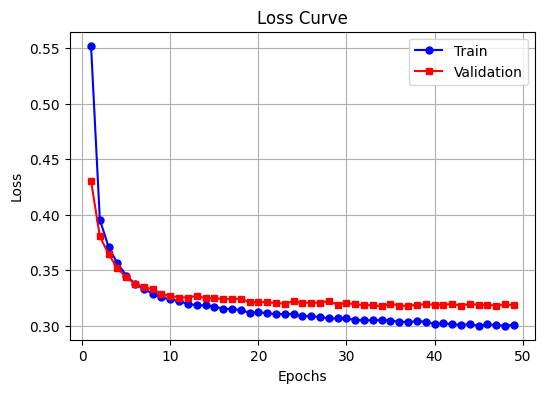

In [12]:
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(6, 4)) 
plt.plot(epochs, train_loss, 'bo-', label='Train', markersize=5, linewidth=1.5)  # Blue with circles
plt.plot(epochs, val_loss, 'rs-', label='Validation', markersize=5, linewidth=1.5)  # Red with squares
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

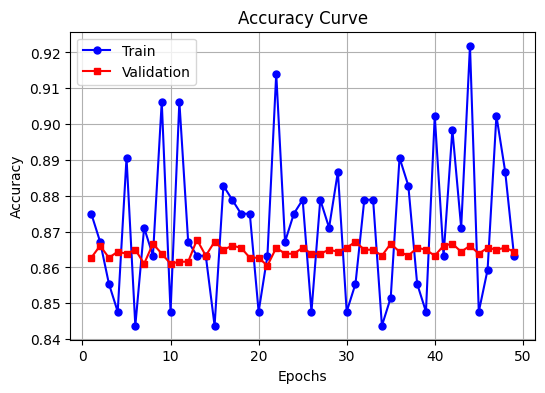

In [13]:
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_acc, 'bo-', label='Train', markersize=5, linewidth=1.5)
plt.plot(epochs, val_acc, 'rs-', label='Validation', markersize=5, linewidth=1.5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()


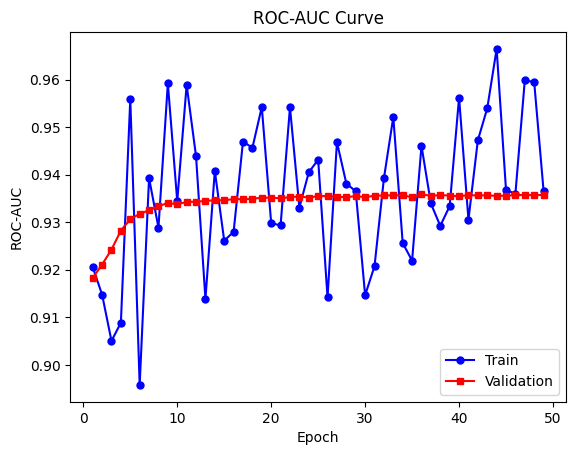

In [14]:
plt.plot(epochs, roc_auc_scores_train, 'bo-', label='Train', markersize=5, linewidth=1.5)
plt.plot(epochs, roc_auc_scores_val, 'rs-', label='Validation', markersize=5, linewidth=1.5)
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC Curve')
plt.legend()
plt.show()


In [15]:
checkpoint = torch.load("/kaggle/working/Resnet18_latent_vectors_classification.pth")
model = ClassificationModel(features.shape[1], 1).to(device)
model.load_state_dict(checkpoint)
model.eval()

test_running_loss = 0.0
correct_predictions_test = 0
total_predictions_test = 0
y_true_test = []
y_scores_test = []

with torch.no_grad():
    for inputs_test, labels_test in dataset_loader.val_loader:
        inputs_test = inputs_test.to(device)
        # Convert labels to float, matching training if necessary
        labels_test = labels_test.to(device).float()
        
        # Permute input dimensions from (B, 32, 32, 2) to (B, 2, 32, 32)
        outputs_test = model(inputs_test)

        
        test_loss_batch = criterion(outputs_test, labels_test)
        test_running_loss += test_loss_batch.item()
        
        predicted_test = (outputs_test > 0.5).float()
        correct_predictions_test += (predicted_test == labels_test).sum().item()
        total_predictions_test += labels_test.size(0)
        
        y_true_test.extend(labels_test.cpu().numpy())
        y_scores_test.extend(outputs_test.cpu().detach().numpy())

# Use the val_loader length for computing average loss
test_loss = test_running_loss / len(dataset_loader.val_loader)
test_accuracy = correct_predictions_test / total_predictions_test
roc_auc_test = roc_auc_score(y_true_test, y_scores_test)
accuracy_test = accuracy_score(y_true_test, (np.array(y_scores_test) > 0.5))

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test ROC-AUC: {roc_auc_test:.4f}")

Test Loss: 0.3177, Test Accuracy: 0.8633, Test ROC-AUC: 0.9357


<ipython-input-15-638707735bee>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/working/Resnet18_latent_vectors_classification.pth")


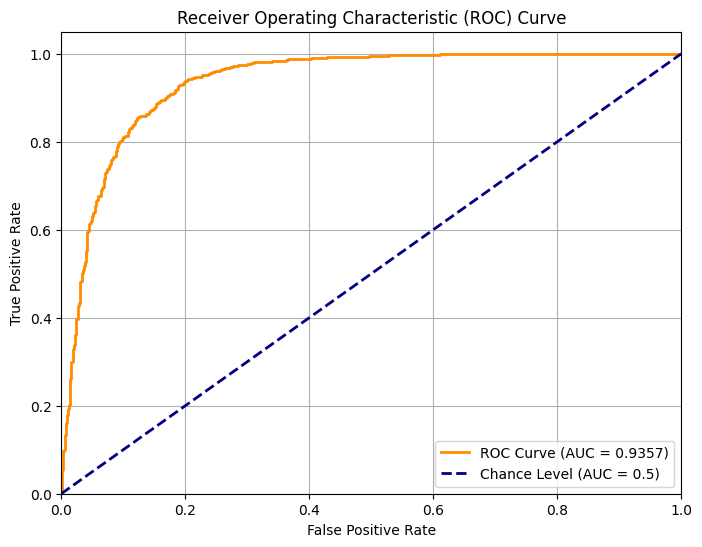

In [17]:

fpr, tpr, _ = roc_curve(y_true_test, y_scores_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance Level (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()